In [1]:
import tensorflow as tf
import numpy as np
import os,pathlib

In [2]:
#方法定义 #get_r_list做了修改

def preprocess_data(dataset):
    all_images = []
    all_labels = []
    for image,label in dataset:
        preprocessed_image = tf.keras.applications.inception_v3.preprocess_input(image)
        all_images.append(preprocessed_image)
        all_labels.append(label)
    return np.concatenate(all_images),np.concatenate(all_labels)

def get_r_list():
    index_mix_list = []
    name_mix_list = []
    for i,layer in enumerate(base_model.layers):
        if layer.name[0:5] == 'mixed':
            index_mix_list.append(i)
            name_mix_list.append(layer.name)
    index_r_list = []
    name_r_list = []
    for j in range(len(name_mix_list)-2):
        if name_mix_list[j][0:7] != name_mix_list[j+1][0:7] and name_mix_list[j][0:7] != name_mix_list[j+2][0:7]:
            index_r_list.append(index_mix_list[j])
            name_r_list.append(name_mix_list[j])
    r_list = [0]
    for i in index_r_list:
        r = i/len(base_model.layers)
        r_list.append(r)
    return r_list

def build_model():
    x = conv_base.output
    predictions = classifier(x)
    model = tf.keras.Model(inputs=conv_base.input,outputs=predictions)
    return model

def r_compiled_model():
    model = build_model()
    for layer in model.layers[:int(r*len(conv_base.layers))+1]:
        layer.trainable = False
    for layer in model.layers[int(r*len(conv_base.layers))+1:]:
        layer.trainable = True
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [3]:
#加载数据、预处理数据

base_dir = pathlib.Path('elephants')
train_dataset = tf.keras.utils.image_dataset_from_directory(base_dir/'train',
                                                            image_size=(224,224),
                                                            batch_size=32)
validation_dataset = tf.keras.utils.image_dataset_from_directory(base_dir/'val',
                                                                 image_size=(224,224),
                                                                 batch_size=32)
train_images,train_labels = preprocess_data(train_dataset)
val_images,val_labels = preprocess_data(validation_dataset)

Found 240 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [5]:
#分类器初训练

base_model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet',include_top=False)

inputs = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
x = tf.keras.layers.Dense(units=256,activation='relu')(x)
outputs = tf.keras.layers.Dense(units=1,activation='sigmoid')(x)
classifier_model = tf.keras.Model(inputs=inputs,outputs=outputs)

x = base_model.output
predictions = classifier_model(x)
model = tf.keras.Model(inputs=base_model.input,outputs=predictions)

for layer in model.layers[:len(base_model.layers)]:
    layer.trainable = False
    
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
callback_list = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2),
                 tf.keras.callbacks.ModelCheckpoint(filepath='inceptionv3_r_1.00.keras',
                                                    monitor='val_accuracy',
                                                    save_best_only=True)]
history = model.fit(train_images,train_labels,
                    epochs=15,
                    validation_data=(val_images,val_labels),
                    callbacks=callback_list)
r_1_acc = max(history.history['val_accuracy'])
print(r_1_acc)

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8/8 [==============================] - ETA: 0s - loss: 2.2293 - accuracy: 0.5083WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001FD019B47B8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

In [6]:
#搜索最佳迁移率R(验证理论)

classifier_p = model.get_layer(model.layers[-1].name)
r_list = get_r_list()
best_acc = r_1_acc
r_acc = []

for i in range(len(r_list)):
    r = r_list[i]
    conv_base = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet',include_top=False)
    classifier = classifier_p
    model = r_compiled_model()
    filepath = 'inceptionv3_r_{:.2f}.keras'.format(r)
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2),
                 tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                    monitor='val_accuracy',
                                                    save_best_only=True)]
    history = model.fit(train_images,train_labels,
                        epochs=15,
                        validation_data=(val_images,val_labels),
                        callbacks=callbacks)
    r_acc.append(max(history.history['val_accuracy']))
    
    if i == 0 and r_acc[0] < r_1_acc:
        r_list = r_list[:1]+r_list[:0:-1]
        continue
    if r_acc[i] > best_acc:
        best_acc = r_acc[i]

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8/8 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.5625WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001FD0184C7B8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

8/8 [==============================] - 20s 2s/step - loss: 0.6013 - accuracy: 0.7042 - val_loss: 0.5910 - val_accuracy: 0.6600
Epoch 2/15
8/8 [==============================] - 16s 2s/step - loss: 0.6055 - accuracy: 0.6792 - val_loss: 0.5744 - val_accuracy: 0.6750
Epoch 3/15
8/8 [==============================] - 17s 2s/step - loss: 0.5905 - accuracy: 0.7542 - val_loss: 0.5695 - val_accuracy: 0.6900
Epoch 4/15
8/8 [==============================] - 16s 2s/step - loss: 0.5710 - accuracy: 0.7542 - val_loss: 0.5621 - val_accuracy: 0.7100
Epoch 5/15
8/8 [==============================] - 16s 2s/step - loss: 0.5683 - accuracy: 0.7542 - val_loss: 0.5582 - val_accuracy: 0.7050
Epoch 6/15
8/8 [==============================] - 16s 2s/step - loss: 0.5632 - accuracy: 0.7833 - val_loss: 0.5579 - val_accuracy: 0.7100
Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'argu

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8/8 [==============================] - 28s 3s/step - loss: 0.6424 - accuracy: 0.6167 - val_loss: 0.6218 - val_accuracy: 0.6600
Epoch 2/15
8/8 [==============================] - 23s 3s/step - loss: 0.6394 - accuracy: 0.6542 - val_loss: 0.5967 - val_accuracy: 0.6550
Epoch 3/15
8/8 [==============================] - 23s 3s/step - loss: 0.6187 - accuracy: 0.6750 - val_loss: 0.5776 - val_accuracy: 0.6650
Epoch 4/15
8/8 [==============================] - 23s 3s/step - loss: 0.6024 - accuracy: 0.7417 - val_loss: 0.5696 - val_accuracy: 0.6700
Epoch 5/15
8/8 [==============================] - 23s 3s/step - loss: 0.5848 - accuracy: 0.7375 - val_loss: 0.5635 - val_accuracy: 0.6950
Epoch 6/15

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8/8 [==============================] - 34s 4s/step - loss: 0.6371 - accuracy: 0.6208 - val_loss: 0.6259 - val_accuracy: 0.6600
Epoch 2/15
8/8 [==============================] - 28s 4s/step - loss: 0.6437 - accuracy: 0.6542 - val_loss: 0.6019 - val_accuracy: 0.6550
Epoch 3/15
8/8 [==============================] - 28s 4s/step - loss: 0.6199 - accuracy: 0.6708 - val_loss: 0.5918 - val_accuracy: 0.6650
Epoch 4/15
8/8 [==============================] - 28s 4s/step - loss: 0.6060 - accuracy: 0.6917 - val_loss: 0.5815 - val_accuracy: 0.6700
Epoch 5/15
8/8 [==============================] - 29s 4s/step - loss: 0.5825 - accuracy: 0.7292 - val_loss: 0.5770 - val_accuracy: 0.6750
Epoch 6/15

In [7]:
#观察结果

print(r_list)
print(r_acc)

[0, 0.8971061093247589, 0.797427652733119, 0.7331189710610932, 0.6302250803858521, 0.5273311897106109, 0.42443729903536975, 0.3215434083601286, 0.2765273311897106, 0.20257234726688103, 0.12861736334405144]
[0.6700000166893005, 0.7549999952316284, 0.7099999785423279, 0.7250000238418579, 0.7450000047683716, 0.7149999737739563, 0.6600000262260437, 0.6899999976158142, 0.7350000143051147, 0.6700000166893005, 0.6899999976158142]


In [9]:
##整理结果

r_list.pop(0)
r_0_acc = r_acc.pop(0)

r_list.append(0)
r_acc.append(r_0_acc)

r_list.insert(0,1)
r_acc.insert(0,r_1_acc)
print(r_list)
print(r_acc)

[1, 0.8971061093247589, 0.797427652733119, 0.7331189710610932, 0.6302250803858521, 0.5273311897106109, 0.42443729903536975, 0.3215434083601286, 0.2765273311897106, 0.20257234726688103, 0.12861736334405144, 0]
[0.6949999928474426, 0.7549999952316284, 0.7099999785423279, 0.7250000238418579, 0.7450000047683716, 0.7149999737739563, 0.6600000262260437, 0.6899999976158142, 0.7350000143051147, 0.6700000166893005, 0.6899999976158142, 0.6700000166893005]


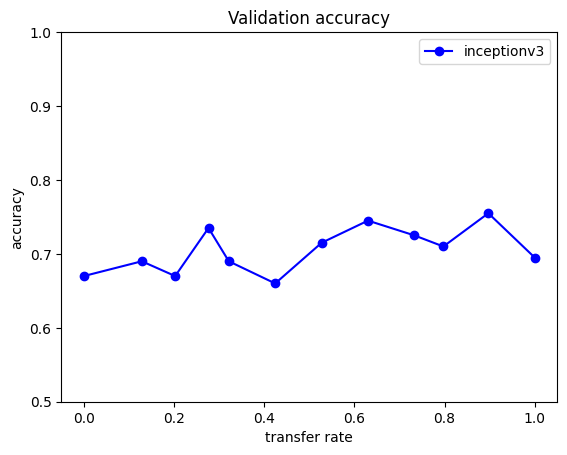

In [10]:
#展示结果

import matplotlib.pyplot as plt
plt.figure()
plt.plot(r_list,r_acc,linestyle='-',marker='o',color='b',label='inceptionv3')
plt.xlabel('transfer rate')
plt.ylabel('accuracy')
plt.ylim((0.5,1))

plt.title('Validation accuracy')
plt.legend()
plt.show()
